# IEEE-CIS Fraud Detection API Demo
Clean, minimal walk-through using the public helpers (`utils_data_io.py` / `utils_post_processing.py`).

**What this shows**
- Build artifacts (dataset → features → heterograph) from the helpers.
- Train baselines (logreg + LightGBM) and the GraphSAGE GNN with a few knobs.
- Inspect GNN metrics and compare against baselines with a tidy table + bar charts.
- Optional: Precision@k and a quick FP/FN peek for storytelling.

In [1]:
import warnings
from pathlib import Path
import json

import matplotlib.pyplot as plt
import pandas as pd

from utils_data_io import (
    load_config,
    build_dataset,
    build_features,
    build_graph,
    train_tabular_baseline,
    train_lgbm_baseline,
    train_gnn_model,
)
from utils_post_processing import (
    compare_models_table,
    load_gnn_error_table,
    precision_recall_at_k,
)

warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Run settings (minimal knobs)
Edit once, rerun this cell, then run top-to-bottom.

In [2]:
# Toggle to reuse existing artifacts instead of rebuilding
USE_EXISTING_ARTIFACTS = True

# Data/build controls
SAMPLE_FRAC = 0.25        # fraction of raw data to sample (0<frac<=1); None for full
MAX_ROWS = 200_000           # cap rows before sampling; None reads all (~590k rows)

# Split lengths
VAL_DAYS = 10             # validation window (days)
TEST_DAYS = 10            # test window (days)

# GraphSAGE training knobs
EPOCHS = 5                # increase if PR-AUC still climbing
HIDDEN_DIM = 160
NUM_LAYERS = 2
DROPOUT = 0.25
LR = 5e-4
THRESHOLD = 0.4
POS_WEIGHT_SCALE = 1.4    # >1 upweights fraud to favor recall/PR-AUC
DEVICE = 'auto'           # 'auto', 'cpu', or 'cuda'

print({k: globals()[k] for k in [
    'USE_EXISTING_ARTIFACTS','SAMPLE_FRAC','MAX_ROWS','VAL_DAYS','TEST_DAYS',
    'EPOCHS','HIDDEN_DIM','NUM_LAYERS','DROPOUT','LR','THRESHOLD','POS_WEIGHT_SCALE','DEVICE'
]})


{'USE_EXISTING_ARTIFACTS': True, 'SAMPLE_FRAC': 0.25, 'MAX_ROWS': 200000, 'VAL_DAYS': 10, 'TEST_DAYS': 10, 'EPOCHS': 5, 'HIDDEN_DIM': 160, 'NUM_LAYERS': 2, 'DROPOUT': 0.25, 'LR': 0.0005, 'THRESHOLD': 0.4, 'POS_WEIGHT_SCALE': 1.4, 'DEVICE': 'auto'}


## Build artifacts (dataset → features → graph)

In [3]:
cfg = load_config()
artifact_paths = {
    'merged': Path(cfg['data']['merged_file']),
    'features': Path(cfg['tabular']['features_out']),
    'graph': Path(cfg['graph']['save_path']),
}

if USE_EXISTING_ARTIFACTS and all(p.exists() for p in artifact_paths.values()):
    print('Reusing existing artifacts:', artifact_paths)
else:
    merged = build_dataset(sample_frac=SAMPLE_FRAC, max_rows=MAX_ROWS)
    feats = build_features()
    graph = build_graph()
    print({'merged': merged, 'features': feats, 'graph': graph})


Reusing existing artifacts: {'merged': PosixPath('data/processed/merged.parquet'), 'features': PosixPath('data/processed/features.parquet'), 'graph': PosixPath('data/artifacts/hetero_graph.pt')}


## Train baselines (logreg + LightGBM)
LightGBM may be skipped on tiny samples; both auto-tune threshold on validation.

In [4]:
baseline_log = train_tabular_baseline(val_days=VAL_DAYS, test_days=TEST_DAYS)
try:
    baseline_lgbm = train_lgbm_baseline(val_days=VAL_DAYS, test_days=TEST_DAYS)
except RuntimeError as exc:
    print('LightGBM baseline skipped:', exc)
except ValueError as exc:
    print('LightGBM baseline skipped (tiny sample):', exc)


[run_baseline] Using fallback 60/20/20 time split for small sample.
{
  "model": "LogisticRegression(balanced)",
  "features": [
    "log_amt",
    "hour",
    "dow",
    "hour_sin",
    "hour_cos",
    "txn_time_norm",
    "hours_since_last_txn",
    "acc_txn_cnt",
    "acc_amt_mean",
    "acc_amt_std",
    "acc_fraud_rate_smooth",
    "has_device_change"
  ],
  "val_days": 10,
  "test_days": 10,
  "threshold": 0.7771804172136392,
  "val_best_f1": 0.32177531206657417,
  "metrics": {
    "val": {
      "PR_AUC": 0.18452194247284648,
      "precision": 0.24116424116424118,
      "recall": 0.48333333333333334,
      "f1": 0.3217753120665742
    },
    "test": {
      "PR_AUC": 0.1492419193497852,
      "precision": 0.16425992779783394,
      "recall": 0.4232558139534884,
      "f1": 0.23667100130039012
    }
  },
  "n_train": 24000,
  "n_val": 8000,
  "n_test": 8000
}
[run_baseline] Using fallback 60/20/20 time split for small sample.
LightGBM baseline skipped (tiny sample): For early st

## Train the GraphSAGE GNN

In [5]:
gnn_run = train_gnn_model(
    epochs=EPOCHS,
    lr=LR,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    threshold=THRESHOLD,
    val_days=VAL_DAYS,
    test_days=TEST_DAYS,
    device=None if DEVICE == 'auto' else DEVICE,
    pos_weight_scale=POS_WEIGHT_SCALE,
)

gnn_run


[train_gnn] Using fallback 60/20/20 time split for small sample.
[Epoch 001] loss=1.6096 val_PR=0.0636 val_F1=0.0583 test_PR=0.0487 test_F1=0.0523
[Epoch 002] loss=1.5711 val_PR=0.0991 val_F1=0.0583 test_PR=0.0657 test_F1=0.0523
[Epoch 003] loss=1.5455 val_PR=0.1311 val_F1=0.0583 test_PR=0.0823 test_F1=0.0523
[Epoch 004] loss=1.5204 val_PR=0.1474 val_F1=0.0583 test_PR=0.0961 test_F1=0.0523
[Epoch 005] loss=1.5001 val_PR=0.1611 val_F1=0.0583 test_PR=0.1067 test_F1=0.0523

Saved model to data/artifacts/gnn_model.pt
Saved metrics to data/artifacts/gnn_metrics.json


{'history': {1: {'loss': 1.6096374988555908,
   'train': {'roc_auc': 0.5842560586866937,
    'pr_auc': 0.0405050984131894,
    'precision': 0.02808333333333333,
    'recall': 1.0,
    'f1': 0.054632406581827025},
   'val': {'roc_auc': 0.5949326138316151,
    'pr_auc': 0.06360537046424389,
    'precision': 0.03,
    'recall': 1.0,
    'f1': 0.05825242718446602},
   'test': {'roc_auc': 0.6023665068482921,
    'pr_auc': 0.048702989148717735,
    'precision': 0.026875,
    'recall': 1.0,
    'f1': 0.05234327449786975}},
  2: {'loss': 1.57106351852417,
   'train': {'roc_auc': 0.6580957024814835,
    'pr_auc': 0.06865348427699448,
    'precision': 0.02808333333333333,
    'recall': 1.0,
    'f1': 0.054632406581827025},
   'val': {'roc_auc': 0.6570492375429553,
    'pr_auc': 0.09909749969405178,
    'precision': 0.03,
    'recall': 1.0,
    'f1': 0.05825242718446602},
   'test': {'roc_auc': 0.6403671341727531,
    'pr_auc': 0.06570777823485875,
    'precision': 0.026875,
    'recall': 1.0,
  

## Model comparison: baselines vs GNN

In [6]:
import pandas as pd

# Ensure compare_models_table is available
try:
    compare_models_table
except NameError:
    from utils_post_processing import compare_models_table

# Harmonize metric names across models
metrics_raw = compare_models_table().copy()
if 'PR_AUC' in metrics_raw.columns:
    metrics_raw['pr_auc'] = metrics_raw.get('pr_auc', metrics_raw['PR_AUC']).fillna(metrics_raw['PR_AUC'])
    metrics_raw.drop(columns=['PR_AUC'], inplace=True, errors='ignore')

summary_cols = ['model', 'split', 'pr_auc', 'precision', 'recall', 'f1', 'roc_auc']
fmt_cols = ['PR-AUC', 'precision', 'recall', 'f1', 'ROC-AUC']
renamed = metrics_raw[summary_cols].rename(columns={'pr_auc': 'PR-AUC', 'roc_auc': 'ROC-AUC'})
results_table = renamed.sort_values(['split', 'model']).reset_index(drop=True)
# Cast metric columns to numeric for safe formatting
for col in fmt_cols:
    if col in results_table.columns:
        results_table[col] = pd.to_numeric(results_table[col], errors='coerce')
# Cast metric columns to numeric for safe formatting
results_table[fmt_cols] = results_table[fmt_cols].apply(pd.to_numeric, errors='coerce')

fmt_cols = ['PR-AUC', 'precision', 'recall', 'f1', 'ROC-AUC']
styled = (
    results_table.style
    .format({col: '{:.4f}' for col in fmt_cols}, na_rep='-')
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'left'), ('background', '#f6f6f6')]},
        {'selector': 'td', 'props': [('padding', '4px 8px')]},
    ])
    .hide(axis="index")
)
styled


model,split,PR-AUC,precision,recall,f1,ROC-AUC
baseline,test,0.1492,0.1643,0.4233,0.2367,-
gnn,test,0.1067,0.1832,0.2837,0.2226,0.6829
gnn,train,0.1370,0.2664,0.1929,0.2238,0.7487
baseline,val,0.1845,0.2412,0.4833,0.3218,-
gnn,val,0.1611,0.2534,0.3125,0.2799,0.7303


### GNN vs baseline (val/test)
Bar charts for key metrics.

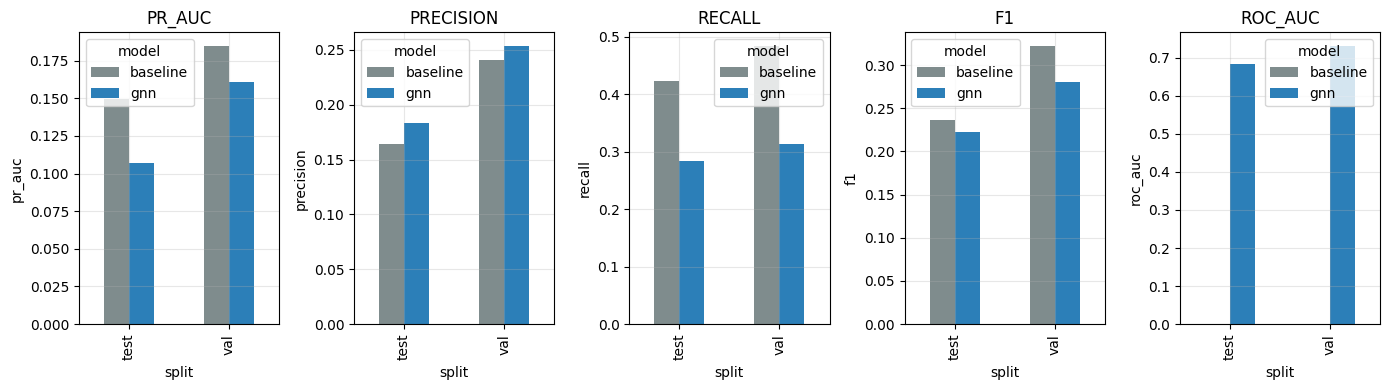

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure compare_models_table is available
try:
    compare_models_table
except NameError:
    from utils_post_processing import compare_models_table

metrics_raw = compare_models_table().copy()
if 'PR_AUC' in metrics_raw.columns:
    metrics_raw['pr_auc'] = metrics_raw.get('pr_auc', metrics_raw['PR_AUC']).fillna(metrics_raw['PR_AUC'])
    metrics_raw.drop(columns=['PR_AUC'], inplace=True, errors='ignore')

keep_cols = ['model', 'split', 'pr_auc', 'precision', 'recall', 'f1', 'roc_auc']
plot_df = metrics_raw[keep_cols].copy()
plot_df = plot_df[plot_df['split'].isin(['val', 'test'])]

if plot_df.empty:
    print('No metrics to plot; run baselines + GNN first.')
else:
    metrics_to_plot = ['pr_auc', 'precision', 'recall', 'f1', 'roc_auc']
    fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(14, 4))
    colors = {'baseline': '#7f8c8d', 'gnn': '#2c7fb8'}
    for ax, m in zip(axes, metrics_to_plot):
        pivot = plot_df.pivot(index='split', columns='model', values=m)
        if set(['baseline','gnn']).issubset(pivot.columns):
            pivot = pivot[['baseline', 'gnn']]
        pivot.plot(kind='bar', ax=ax, color=[colors.get(col, '#555') for col in pivot.columns])
        ax.set_title(m.upper())
        ax.set_xlabel('split'); ax.set_ylabel(m)
        ax.legend(title='model'); ax.grid(alpha=0.3)
    plt.tight_layout(); plt.show()


## Precision@k (validation set)

In [8]:
pred_path = Path('data/artifacts/gnn_val_test_preds.parquet')
if not pred_path.exists():
    print('Run the GNN training cell to produce gnn_val_test_preds.parquet')
else:
    preds = load_gnn_error_table()
    val = preds[preds['split'] == 'val']
    if 'isFraud' in val.columns:
        p_at_5, r_at_5 = precision_recall_at_k(val['prob'], val['isFraud'], 0.05)
        print({'precision@5%': p_at_5, 'recall@5%': r_at_5})
    display(val.head())


{'precision@5%': 0.22, 'recall@5%': 0.36666666666666664}


,split,TransactionID,card1,TransactionDT,isFraud,prob,pred_label,error_type
0,val,3011000,5465,607658,0,0.554743,0,correct
1,val,3011001,18227,607669,0,0.571868,0,correct
2,val,3011002,6252,607689,0,0.569916,0,correct
3,val,3011003,14858,607704,0,0.575408,0,correct
4,val,3011004,11162,607718,1,0.631789,0,FN


## Quick FP/FN examples

In [9]:
pred_path = Path('data/artifacts/gnn_val_test_preds.parquet')
if not pred_path.exists():
    print('Run the GNN training cell to produce gnn_val_test_preds.parquet')
else:
    preds = load_gnn_error_table()
    fp = preds[preds['error_type'] == 'FP'].sort_values('prob', ascending=False).head(5)
    fn = preds[preds['error_type'] == 'FN'].sort_values('prob', ascending=True).head(5)
    display({'false_positives': fp, 'false_negatives': fn})


{'false_positives':       split  TransactionID card1  TransactionDT  isFraud      prob  \
 6425    val        3017425  9635         763150        0  0.871551   
 11800  test        3022800  9635         868191        0  0.853149   
 3929    val        3014929  3867         696651        0  0.847065   
 3976    val        3014976  3867         697489        0  0.843168   
 3981    val        3014981  3867         697602        0  0.840607   
 
        pred_label error_type  
 6425            1         FP  
 11800           1         FP  
 3929            1         FP  
 3976            1         FP  
 3981            1         FP  ,
 'false_negatives':       split  TransactionID card1  TransactionDT  isFraud      prob  \
 4080    val        3015080  7919         699663        1  0.500184   
 11553  test        3022553  7664         864694        1  0.511350   
 10460  test        3021460  2616         851481        1  0.515185   
 10959  test        3021959  2616         856897        1